In [1]:
import connect_tools as ct
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import Ml_Tools as Mt

In [2]:
password = ""
connexion = ct.Connect_Tools(password=password)
df_matches = connexion.read_db(table_name="matches")
df_champions = connexion.read_db(table_name="champions_list")
df_matches.dropna(inplace=True)
print(len(df_matches))
print(df_matches.isnull().sum())

list_champ = df_champions["name_champ"].to_list()

df_columns_red = ["red_" + c for c in list_champ]
df_columns_blu = ["blu_" + c for c in list_champ]

dict_columns_red = {col: [] for col in df_columns_red}
dict_columns_blu = {col: [] for col in df_columns_blu}

dict_win_side = {"win_side" : df_matches["win_side"].to_list()}

def create_code_comp(side : str):

    start_col = 1 if side == "red_" else 6
    end_col = start_col + 5
    columns = df_matches.iloc[:,start_col:end_col]

    x = dict_columns_red if side == "red_" else dict_columns_blu

    def series_champ(row):
        for col, position in x.items():
            for j, value in enumerate(row):
                if col == f"{side}"+ value:
                    position.append(j + 1)
                    break
            else :
                position.append(0)

    for row in columns.values:
        series_champ(row)

create_code_comp("red_")
create_code_comp("blu_")

dict_df = {**dict_columns_red, **dict_columns_blu, **dict_win_side}
df_ml = pd.DataFrame(dict_df)
print(df_ml.shape)
connexion.req_interne(order="TRUNCATE TABLE `ml_champions`")
connexion.insert_db(dataframe = df_ml, table_name = "ml_champions")
connexion.close_conn()


35931
id_match            0
red_top             0
red_jun             0
red_mid             0
red_bot             0
red_sup             0
blu_top             0
blu_jun             0
blu_mid             0
blu_bot             0
blu_sup             0
win_side            0
riot_id_match       0
ref_id_summoners    0
dtype: int64
(35931, 335)
1146 (42S02): Table 'cassiopeia.ml_champions' doesn't exist


In [8]:
def df_para_rfc():
    """Create a database for all parametres of randomforestclassifier"""
    password = ""
    connexion = ct.Connect_Tools(password=password)
    df_ml_champions = connexion.read_db(table_name = "ml_champions")

    RFC = Mt.Ml_Tools(columns = df_ml_champions.iloc[:,0:334], target = df_ml_champions.loc[:,"win_side"])
    df_RFC = RFC.calibrate_RFC()

    connexion.insert_db(dataframe = df_RFC, table_name="para_rfc")
    connexion.close_conn()

In [9]:
password = ""
connexion = ct.Connect_Tools(password=password)
df_ml_champions = connexion.read_db(table_name = "ml_champions")
connexion.close_conn()

x = df_ml_champions.iloc[:,0:334]
print(x)
y = df_ml_champions.loc[:,"win_side"]
print(y)


       red_Aatrox  red_Ahri  red_Akali  red_Akshan  red_Alistar  red_Amumu  \
0               0         0          0           0            0          0   
1               0         0          0           0            0          0   
2               0         0          0           0            0          0   
3               0         0          3           0            0          0   
4               0         0          0           0            0          0   
...           ...       ...        ...         ...          ...        ...   
35926           0         3          0           0            0          0   
35927           0         3          0           0            0          0   
35928           0         0          0           0            0          0   
35929           0         0          0           0            0          0   
35930           0         0          0           0            0          0   

       red_Anivia  red_Annie  red_Aphelios  red_Ashe  ...  blu_

In [10]:
columns_select = x.columns.to_list()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)
print(x_train.shape)

(28744, 334)


In [12]:
numeric_features = columns_select 
numeric_transformer = StandardScaler()

feature_encoder = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)])
X_train = feature_encoder.fit_transform(x_train)
print(X_train[0:5,:])

[[-0.23417923 -0.27950829 -0.20121616 ... -0.15271883 -0.10132053
  -0.13704066]
 [-0.23417923 -0.27950829 -0.20121616 ... -0.15271883 -0.10132053
  -0.13704066]
 [-0.23417923 -0.27950829 -0.20121616 ... -0.15271883 -0.10132053
  -0.13704066]
 [-0.23417923 -0.27950829 -0.20121616 ... -0.15271883 -0.10132053
  -0.13704066]
 [-0.23417923 -0.27950829 -0.20121616 ... -0.15271883 -0.10132053
  -0.13704066]]


In [16]:
password = ""
connexion = ct.Connect_Tools(password=password)
df_para_RDC = connexion.read_db(table_name="para_RDC")
connexion.close_conn
index_esti_RDC = df_para_RDC["Score Test"].idxmax()
score_max = df_para_RDC.loc[index_esti_RDC,"Score Test"]
print(f"Score Test max : {score_max}")
estimators = df_para_RDC.loc[index_esti_RDC, "Depth"]
print(estimators)
criterion_Type = df_para_RDC.loc[index_esti_RDC, "Criterion Type"]
print(criterion_Type)

Score Test max : 0.5370808404062891
50
log_loss


In [14]:
classifier = RandomForestClassifier(n_estimators = estimators, criterion = criterion_Type)
classifier.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', n_estimators=50)

In [17]:
y_train_pred = classifier.predict(x_train)

In [18]:
y_test_pred = classifier.predict(x_test)

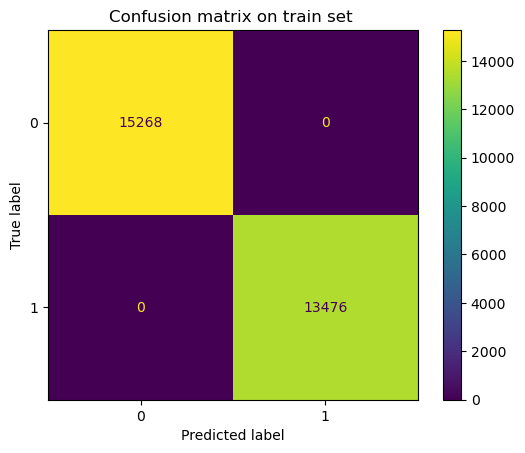

Accuracy-score on train set : 1.000


In [19]:
# Plot confusion matrix on train set
cm = confusion_matrix(y_train, y_train_pred, labels=classifier.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
cm_display.ax_.set_title("Confusion matrix on train set ") 
plt.show() 
print(f"Accuracy-score on train set : {classifier.score(x_train, y_train):.3f}")

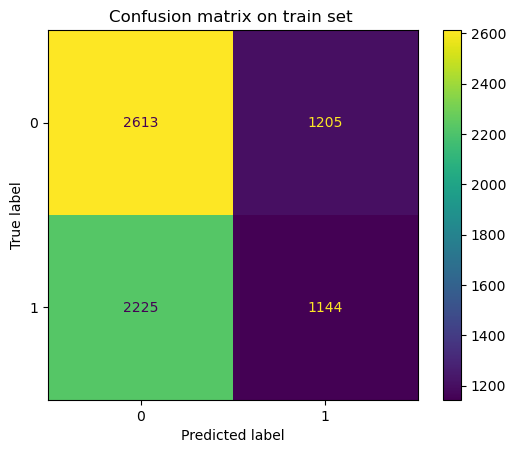

Accuracy-score on train set : 0.523


In [20]:
# Plot confusion matrix on test set
cm = confusion_matrix(y_test, y_test_pred, labels=classifier.classes_)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
cm_display.ax_.set_title("Confusion matrix on train set ") 
plt.show() 
print(f"Accuracy-score on train set : {classifier.score(x_test, y_test):.3f}")

In [21]:


feature_importance = pd.DataFrame({
    "feature_names": columns_select,
    "coefficients": classifier.feature_importances_
                                        
})
feature_importance

,feature_names,coefficients
0,red_Aatrox,0.004600
1,red_Ahri,0.003730
2,red_Akali,0.004414
3,red_Akshan,0.003328
4,red_Alistar,0.002563
...,...,...
329,blu_Zeri,0.004238
330,blu_Ziggs,0.001290
331,blu_Zilean,0.002579
332,blu_Zoe,0.001667


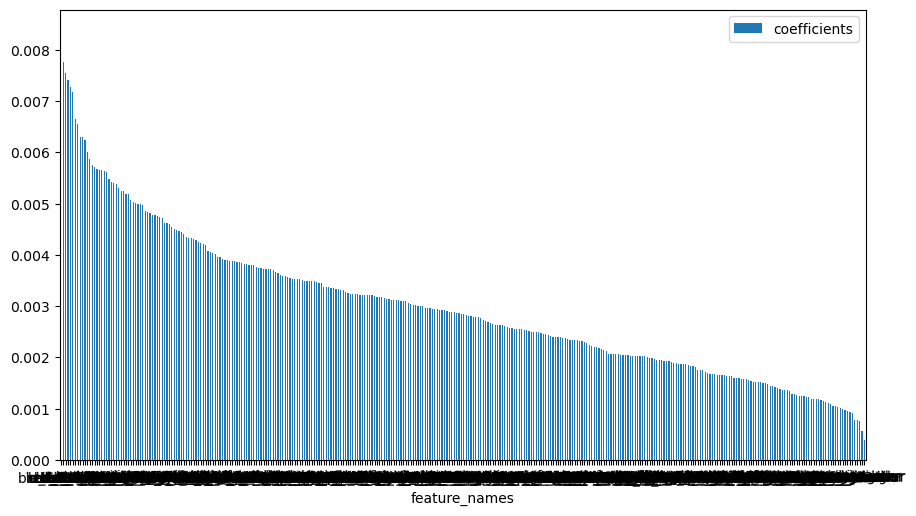

In [22]:
_ = feature_importance.sort_values(by="coefficients", ascending=False).plot(kind="bar", x="feature_names", figsize=(16*.65, 9*.65))
_ = plt.xticks(rotation=1)

In [23]:
name_exel = "C:/Users/utilisateur/Desktop/FeaturesImportances/Troisieme_essai_RFDT"
feature_importance.to_csv(name_exel)